<a href="https://colab.research.google.com/github/Sloba98/Laundry-Image-Classification/blob/restnet-base_model/RestNet_50_base_model_with_validatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from torch import optim
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


In [3]:
from PIL import Image
from torchvision import transforms

In [4]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

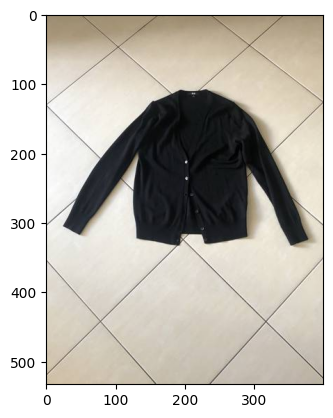

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/Laundry-Image-Classification-main/inputs/train/longsleeve/00588f87-cda1-46d7-93be-71f0fa889895.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

In [6]:
class ImageNetPreprocessing(nn.Module):
    def __init__(self):
        super(ImageNetPreprocessing, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406])
        self.std = torch.tensor([0.229, 0.224, 0.225])

    def forward(self, x):
        mean = self.mean.to(x.device)
        std = self.std.to(x.device)

        x = x[:, [2, 1, 0], :, :]  # Convert RGB to BGR
        x = (x - mean[None, :, None, None]) / std[None, :, None, None]
        return x

In [7]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [8]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
num_classes = 10
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

learning_rate = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Laundry-Image-Classification-main/inputs/train', transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

validate_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Laundry-Image-Classification-main/inputs/validation', transform=train_transforms)
validation_loader = DataLoader(validate_dataset, batch_size=32, shuffle=True, num_workers=2)

In [10]:
train_loss = []
train_accuracy = []

valid_loss = []
valid_accuracy = []

num_epochs = 32
for epoch in range(num_epochs):

    # Training phase
    resnet.train()

    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        accuracy = calculate_accuracy(outputs, labels)
        running_loss += loss.item()
        running_accuracy += accuracy

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = running_accuracy / len(train_loader)

    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)

    # Validation phase
    resnet.eval()

    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    epoch_valid_loss = running_loss / len(validation_loader)
    epoch_valid_accuracy = running_corrects.double() / total

    valid_loss.append(epoch_valid_loss)
    valid_accuracy.append(epoch_valid_accuracy.item())

    print(f'Epoch {epoch+1}, '
          f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, '
          f'Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {epoch_valid_accuracy:.4f}')


Epoch 1, Train Loss: 1.3627, Train Accuracy: 0.5644, Valid Loss: 0.9054, Valid Accuracy: 0.7449
Epoch 2, Train Loss: 0.7709, Train Accuracy: 0.7597, Valid Loss: 0.7513, Valid Accuracy: 0.7625
Epoch 3, Train Loss: 0.6491, Train Accuracy: 0.7898, Valid Loss: 0.6786, Valid Accuracy: 0.7801
Epoch 4, Train Loss: 0.5714, Train Accuracy: 0.8219, Valid Loss: 0.6273, Valid Accuracy: 0.8152
Epoch 5, Train Loss: 0.5200, Train Accuracy: 0.8331, Valid Loss: 0.5731, Valid Accuracy: 0.8094
Epoch 6, Train Loss: 0.4829, Train Accuracy: 0.8524, Valid Loss: 0.5659, Valid Accuracy: 0.8094
Epoch 7, Train Loss: 0.4726, Train Accuracy: 0.8431, Valid Loss: 0.5395, Valid Accuracy: 0.8152
Epoch 8, Train Loss: 0.4338, Train Accuracy: 0.8596, Valid Loss: 0.5222, Valid Accuracy: 0.8123
Epoch 9, Train Loss: 0.4149, Train Accuracy: 0.8599, Valid Loss: 0.5288, Valid Accuracy: 0.8182
Epoch 10, Train Loss: 0.4067, Train Accuracy: 0.8591, Valid Loss: 0.5580, Valid Accuracy: 0.8094
Epoch 11, Train Loss: 0.3992, Train Acc

Train accuracy in the last epoch: 0.9137369791666666, validation accuracy: 0.7624633431085044


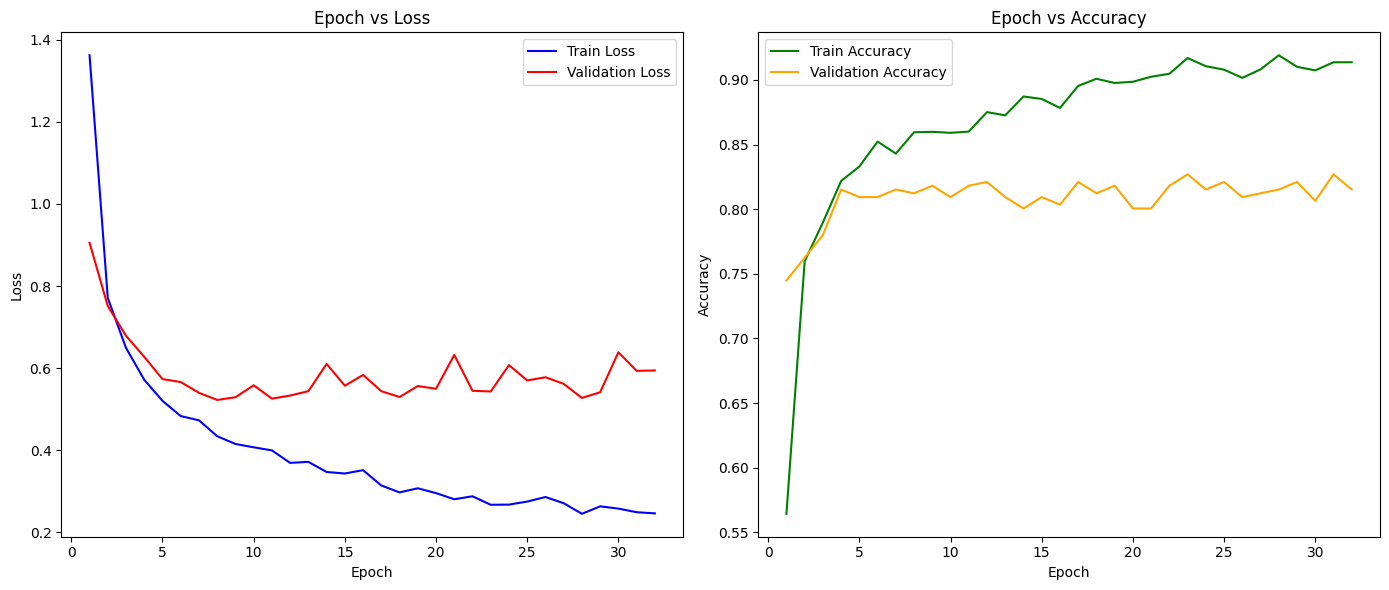

In [11]:
train_loss = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_loss]
train_accuracy = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracy]

valid_loss = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in valid_loss]
valid_accuracy = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in valid_accuracy]

print(f"Train accuracy in the last epoch: {train_accuracy[-1]}, validation accuracy: {valid_accuracy[1]}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, color='b', label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_loss, color='r',  label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy, color='g', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracy, color='orange', label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
torch.save(resnet.state_dict(), 'resnet_base_32')